# Overview:
In this notebook, we will be looking at sentiment analysis using recent tweets with a specific hashtag from a number of states in the US. <br>

This notebook provides the code to:
- Automatically get longitude and lattitude information from geocode.xyz to feed into locator of tweet identifier
- Use tweepy package to extract most recent tweets based on search_word, specified date (all tweets up to this date) and location of users
- Clean extracted tweets
- Analyse sentiments of cleaned tweets using TextBlob by assining a polarity coefficient to each:
    - TextBlob is a Lexicon-based or rule-based sentiment analyser. Each word is given a score based on a predefined word and weight dictionary. The aggregation of these individual scores result in an estimate for the sentence's polarity
- Aggregate findings to map out relative sentiment in locations of interest

<b> Note: </b> Both Twitter API and geocode.xyz API limit the number of searches that you can run using tokens and authentification code

## Import packages used for analysis

In [53]:
import os
import tweepy as tw
import pandas as pd
import geocoder
import urllib.parse
import http.client
from textblob import TextBlob
import re

import matplotlib.pyplot as plt

### 1. Define location lattitude and longitude using geocode.xyz API

In [7]:
def get_long_latt(locate):
    """
    This function takes in the name in string of the location of interest and returns the value of longitude and lattitude
    of that location.
    Note:
    ----
    The function requires auth code obtained through registered user of geocode
    """
    conn = http.client.HTTPConnection('geocode.xyz')
    params = urllib.parse.urlencode({
        'auth': 'XXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'locate': locate,
        'region': "US",
        'geoit': "csv",
        'json': 0
        })
    conn.request('GET', '/?{}'.format(params))
    res = conn.getresponse()
    
    data = res.read().decode("utf-8").split(",")
    if len(data)>0:  ##### search returns a legitimate result
        return ",".join([data[2],data[3]])
    else:
        return "Location not found"

In [8]:
# Top US states for twitter user base
state_list = ["California","Texas","Florida","Illinois","New York"]

In [9]:
# Store the geo info in a dict
state_loc = {}
for state in state_list:
    state_loc[state] = get_long_latt(state)

### 2. Using Tweepy to search for tweets with specific hashtags

In [4]:
# Infomation on twitter's authentification
consumer_key= 'XXXXXXXXXXXXXXXXXXXXXXXXXX'
consumer_secret= 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token= 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token_secret= 'XXXXXXXXXXXXXXXXXXXXXXXXXX'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [41]:
# Define the search term and the date_since date as variables
search_words = "#Mood -is:retweet"   # excluding retweet
date_till = "2022-03-22"             # only include tweets up to this date, note that twitter only allows extraction of limited nummber of tweets / day 
geo_state = [i for i in state_loc.keys()]
geolist = [i + ",500mi" for i in state_loc.values()] # Define the radius of search range to be 100mi around the centre 

# Initialise tweepy object to extract tweets with a specific keyword from a specified location
tweets_state_list = []
for i in geolist:
    tweets = tw.Cursor(api.search_tweets,
              q=search_words,
              lang="en",tweet_mode ="extended",geocode=i,until=date_till).items(500) # twitter limit the number of extractable tweets
    tweets_state_list.append(tweets)

In [42]:
# Collect tweets with defined criteria
tweet_sum = []
for i in range(len(tweets_state_list)):
    tweet_data= [[tweet.user.id,tweet.user.location,tweet.user.followers_count,tweet.user.friends_count,tweet.user.description,
              tweet.created_at,tweet.retweet_count,tweet.favorite_count,tweet.full_text] for tweet in tweets_state_list[i]]
    columns=["user_id","user_location","no_followers","no_friends","acc_des","tweet_created_at","no_retweets","no_favourite","content"]
    df = pd.DataFrame(data = tweet_data,columns=columns)
    df["search_location"] = geo_state[i]  
    tweet_sum.append(df)

In [43]:
# Write data into a presentable dataframe
df_all = pd.concat(tweet_sum)
# df_all.to_csv("pull_tweet.csv")   #save the data to csv file for future use

In [44]:
df_all.head()

,user_id,user_location,no_followers,no_friends,acc_des,tweet_created_at,no_retweets,no_favourite,content,search_location
0,1415386899670126598,"California, USA",26,30,,2022-03-21 21:29:05+00:00,0,1,For Tonight @giveon #mood,California
1,189387620,"Portsmouth, VA",475,629,"LIVE, LOVE, LAUGH...Make the best of every mom...",2022-03-21 20:55:01+00:00,0,2,"#mood because if not me, my family taking him ...",California
2,53427883,"Atlanta, GA",88,55,Plus Boutique \nCome take a peek!,2022-03-21 20:29:16+00:00,0,0,Restocked they leaving fast!😜\n#cornbreadfed® ...,California
3,39459178,NYC,2264,2108,Always put Christ first. Cool NYC events/Fundr...,2022-03-21 19:48:48+00:00,2,3,"It’s about good vibes. You can count on it, t...",California
4,39459178,NYC,2264,2108,Always put Christ first. Cool NYC events/Fundr...,2022-03-21 19:47:50+00:00,3,4,"It’s about good vibes. You can count on it, t...",California


### 3. Clean text and get tweet sentiments with Textblob

In [33]:
# Define unitility functions
def clean_tweet(tweet):
    '''
    This function to clean tweet text by removing links, special characters, specifically the function operates by
    find any express with a-z and number and unicode \w followed by \S Matches any character which is not a whitespace character
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(clean_tweet):
    '''
    This function classifies sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 1 ### positive
    elif analysis.sentiment.polarity == 0:
        return 0  ### neutral
    else:
        return -1 ### negative

In [48]:
# Add clean tweet and sentiment to the original dataframe
df_all["clean_tweet"] = df_all["content"].apply(clean_tweet)
df_all["sentiment"] = df_all["clean_tweet"].apply(get_tweet_sentiment)

In [49]:
df_all.head(5)

,user_id,user_location,no_followers,no_friends,acc_des,tweet_created_at,no_retweets,no_favourite,content,search_location,clean_tweet,sentiment
0,1415386899670126598,"California, USA",26,30,,2022-03-21 21:29:05+00:00,0,1,For Tonight @giveon #mood,California,For Tonight mood,0
1,189387620,"Portsmouth, VA",475,629,"LIVE, LOVE, LAUGH...Make the best of every mom...",2022-03-21 20:55:01+00:00,0,2,"#mood because if not me, my family taking him ...",California,mood because if not me my family taking him out,0
2,53427883,"Atlanta, GA",88,55,Plus Boutique \nCome take a peek!,2022-03-21 20:29:16+00:00,0,0,Restocked they leaving fast!😜\n#cornbreadfed® ...,California,Restocked they leaving fast cornbreadfed mood ...,1
3,39459178,NYC,2264,2108,Always put Christ first. Cool NYC events/Fundr...,2022-03-21 19:48:48+00:00,2,3,"It’s about good vibes. You can count on it, t...",California,It s about good vibes You can count on it the ...,1
4,39459178,NYC,2264,2108,Always put Christ first. Cool NYC events/Fundr...,2022-03-21 19:47:50+00:00,3,4,"It’s about good vibes. You can count on it, t...",California,It s about good vibes You can count on it the ...,1


In [50]:
# Explore the final dataframe
print(f'Maxmimum timestamp {df.tweet_created_at.max()}')
print(f'Minimum timestamp {df.tweet_created_at.min()}')

Maxmimum timestamp 2022-03-21 21:29:05+00:00
Minimum timestamp 2022-03-14 14:16:06+00:00


### 4. Visualise results 

Text(0.5, 1.0, 'Aggregated sentiment analysis in 5 US states from 14-21 Mar 2022')

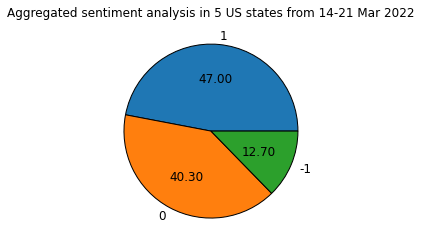

In [56]:
plt.pie(x=df_all.sentiment.value_counts(), autopct="%.2f", labels=df_all.sentiment.value_counts().index,radius=1, wedgeprops={'linewidth' : 1, 'edgecolor' : 'k' }, 
            textprops=dict(fontsize=12));
plt.title("Aggregated sentiment analysis in 5 US states from 14-21 Mar 2022")

In [37]:
summary = df_all.groupby(by=["search_location","sentiment"]).size()

In [40]:
pd.crosstab(index=df_all.search_location,columns=df_all.sentiment)

sentiment,-1,0,1
search_location,,,
California,2,16,13
Florida,16,40,56
Illinois,0,1,0
New York,14,43,61
Texas,1,5,8


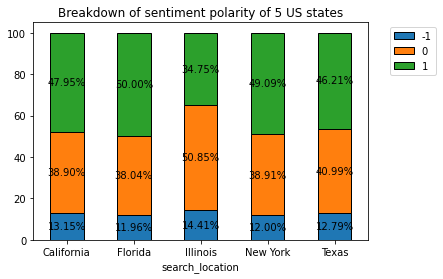

In [69]:
# Using 100% bar chart to visualise
prob = pd.crosstab(index=df_all.search_location,columns=df_all.sentiment,normalize="index")# turn into percentage
prob=prob*100
prob.plot.bar(rot=0, stacked=True, edgecolor="k")

for j,i in zip(prob.index,range(len(prob.index))):
    for cs, z in zip(prob.loc[j,:].cumsum(), prob.loc[j,:]):
        plt.text(i,cs-z/2, f'{z:.2f}%', va = 'center', ha = 'center')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Breakdown of sentiment polarity of 5 US states")
plt.show()